In [26]:
import numpy as np
import tensorflow as tf
from detect_outlier import *
from tensorflow.keras.metrics import Metric
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from collections import defaultdict



In [27]:
df_normalized = read_data()
df_normalized.dropna(inplace=True)


- Thử thêm label là điểm ở giữa
- Lấy đầu ra của giải thuật di truyền để làm input

In [28]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=second_y, test_size=0.2, random_state=40
)
y = np.stack((first_y, second_y), axis=1)
y_array2d = np.stack((first_y_train, second_y_train), axis=1)
y_test_array2d = np.stack((first_y_test, second_y_test), axis=1)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(14,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

In [30]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(
        self,
        from_logits=False,
        reduction=tf.keras.losses.Reduction.AUTO,
        name="custom_sparse_categorical_crossentropy",
    ):
        super().__init__(reduction=reduction, name=name)
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        # Calculate the standard sparse categorical crossentropy loss
        min_losses = []
        first_label = tf.cast(y_true[:, 0], tf.int32)
        second_label = tf.cast(y_true[:, 1], tf.int32)

        first_scce_loss = tf.keras.losses.sparse_categorical_crossentropy(
            first_label, y_pred, from_logits=self.from_logits
        )
        second_scce_loss = tf.keras.losses.sparse_categorical_crossentropy(
            second_label, y_pred, from_logits=self.from_logits
        )      
        return tf.reduce_min(tf.stack([first_scce_loss, second_scce_loss], axis=0), axis=0)
class CustomAccuracy(Metric):
    def __init__(self, **kwargs):
        super(CustomAccuracy, self).__init__(**kwargs)
        self.correct = self.add_weight("correct", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        # Cast y_true to the same dtype as y_pred
        first_label = tf.cast(y_true[:, 0], y_pred.dtype)
        second_label = tf.cast(y_true[:, 1], y_pred.dtype)
        # Check the equality of the prediction and truth
        values = tf.cast(tf.logical_or(tf.equal(y_pred, first_label), tf.equal(y_pred, second_label)), 'float32')
        self.correct.assign_add(tf.reduce_sum(values))
        self.total.assign_add(tf.cast(tf.size(first_label), 'float32'))

    def result(self):
        return self.correct / self.total

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)

# Example usage of the custom loss function
custom_accuracy = CustomAccuracy()
custom_loss = CustomSparseCategoricalCrossentropy()

In [31]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_accuracy])
model.fit(X_train, y_array2d , epochs=10, batch_size=32)

Epoch 1/10
1987/1987 [==============================] - 2s 823us/step - loss: 2.5317 - custom_accuracy_2: 0.9197
Epoch 2/10
1987/1987 [==============================] - 2s 823us/step - loss: 1.1042 - custom_accuracy_2: 0.9466
Epoch 3/10
1987/1987 [==============================] - 2s 835us/step - loss: 0.7232 - custom_accuracy_2: 0.9551
Epoch 4/10
1987/1987 [==============================] - 2s 938us/step - loss: 0.4747 - custom_accuracy_2: 0.9605
Epoch 5/10
1987/1987 [==============================] - 2s 1ms/step - loss: 0.3497 - custom_accuracy_2: 0.9619
Epoch 6/10
1987/1987 [==============================] - 2s 1ms/step - loss: 0.2558 - custom_accuracy_2: 0.9663
Epoch 7/10
1987/1987 [==============================] - 2s 900us/step - loss: 0.1890 - custom_accuracy_2: 0.9678
Epoch 8/10
1987/1987 [==============================] - 2s 802us/step - loss: 0.1494 - custom_accuracy_2: 0.9693
Epoch 9/10
1987/1987 [==============================] - 2s 788us/step - loss: 0.1282 - custom_accura

In [32]:
# X_new = np.expand_dims(X_test, axis=0)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
print("Dự đoán:", predicted_labels)

497/497 [==============================] - 0s 598us/step
Dự đoán: [1 1 2 ... 1 1 1]


In [33]:
print(new_accuracy(first_y_test, second_y_test, predicted_labels))
# print(new_f1_score(first_y_test, second_y_test, predicted_labels))
# print(precision_recall(first_y_test, second_y_test, predicted_labels))

0.9765305480400176


In [34]:
from collections import defaultdict

first_label = first_y_test
second_label = second_y_test
pred_label = predicted_labels
count3 = defaultdict(
    lambda: defaultdict(int)
)  # key: pair_label, value: {key: unique label, value: number of label}

# Xác định các cặp label

for i in range(len(first_label)):
    pair = (
        min(first_label[i], second_label[i]),
        max(first_label[i], second_label[i]),
    )
    count3[pair][pred_label[i]] += 1
    
count_TP = defaultdict(int)
count_FP = defaultdict(int)
count_FN = defaultdict(int)
count_total = defaultdict(int)

for pair, value in count3.items():
    for key, count in value.items():
        if key in pair:
            count_TP[key] += count
        else:
            count_FP[key] += count
            count_FN[pair[0]] +=count
            if pair[0] != pair[1]:
                count_FN[pair[1]] +=count
        count_total[key] += count
precision = {}
recall = {}
f1 = {}
for label in count_TP.keys():
    tp = count_TP[label]
    fp = count_FP[label]
    fn = count_FN[label]

    if tp + fp > 0:
        precision[label] = tp / (tp + fp)
    else:
        precision[label] = 0

    if tp + fn > 0:
        recall[label] = tp / (tp + fn)
    else:
        recall[label] = 0
        
    if precision[label] + recall[label] > 0:
        f1[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
    else:
        f1[label] = 0
avg_precision = sum(precision.values()) / len(precision) if precision else 0
avg_recall = sum(recall.values()) / len(recall) if recall else 0
avg_f1 = sum(f1.values()) / len(f1) if f1 else 0


total_instances = sum(count_total.values())
weighted_precision = sum(precision[label] * count_total[label] for label in precision.keys()) / total_instances if total_instances > 0 else 0
weighted_recall = sum(recall[label] * count_total[label] for label in recall.keys()) / total_instances if total_instances > 0 else 0
weighted_f1 = sum(f1[label] * count_total[label] for label in f1.keys()) / total_instances if total_instances > 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1 Score:", weighted_f1)

Precision: {1: 0.9881559467017602, 2: 0.9861687413554634, 3: 0.7687165775401069, 4: 0.8333333333333334, 0: 0.8285714285714286}
Recall: {1: 0.9956078561365708, 2: 0.9292929292929293, 3: 0.9896729776247849, 4: 0.34965034965034963, 0: 0.3972602739726027}
F1 Score: {1: 0.9918679050567595, 2: 0.9568864284516021, 3: 0.8653122648607976, 4: 0.49261083743842365, 0: 0.5370370370370371}
Average Precision: 0.8809892055004186
Average Recall: 0.7322968773354475
Average F1 Score: 0.768742894568924
Weighted Precision: 0.9765305480400176
Weighted Recall: 0.9795050641323212
Weighted F1 Score: 0.9766596653508206


In [35]:
count3

defaultdict(<function __main__.<lambda>()>,
            {(1.0, 1.0): defaultdict(int, {1: 11622, 2: 10, 0: 4}),
             (2.0,
              2.0): defaultdict(int, {2: 2852, 1: 141, 3: 71, 0: 2, 4: 2}),
             (3.0, 4.0): defaultdict(int, {3: 272, 4: 13}),
             (0.0, 1.0): defaultdict(int, {1: 392, 2: 28, 4: 2, 0: 17, 3: 9}),
             (3.0, 3.0): defaultdict(int, {3: 275, 4: 5}),
             (4.0, 4.0): defaultdict(int, {3: 93, 4: 37}),
             (0.0, 0.0): defaultdict(int, {0: 12, 1: 3, 2: 2}),
             (2.0, 3.0): defaultdict(int, {3: 28, 4: 1})})

In [36]:

unique_labels, counts = np.unique(predicted_labels, return_counts=True)
label_count_dict = dict(zip(unique_labels, counts))
print(label_count_dict)

{0: 35, 1: 12158, 2: 2892, 3: 748, 4: 60}


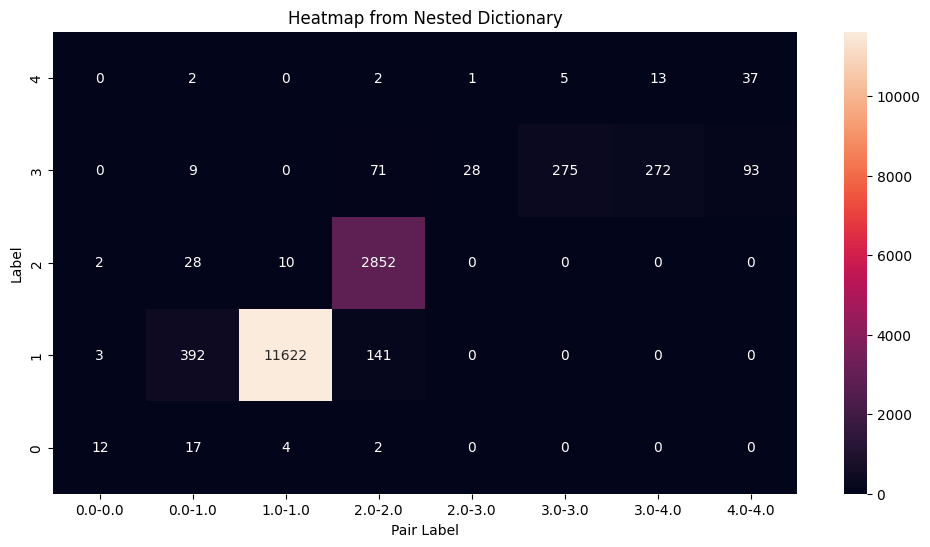

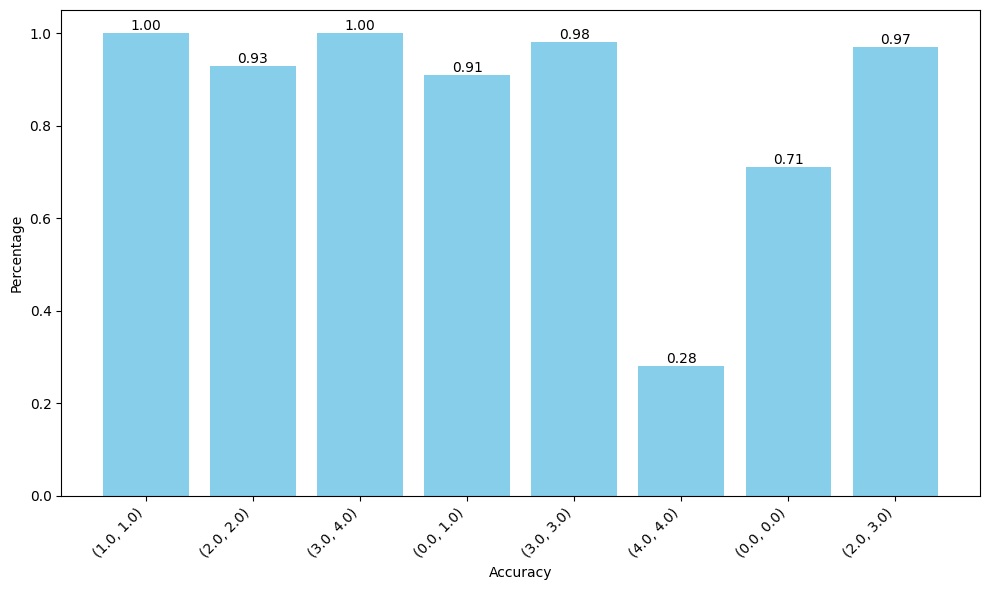

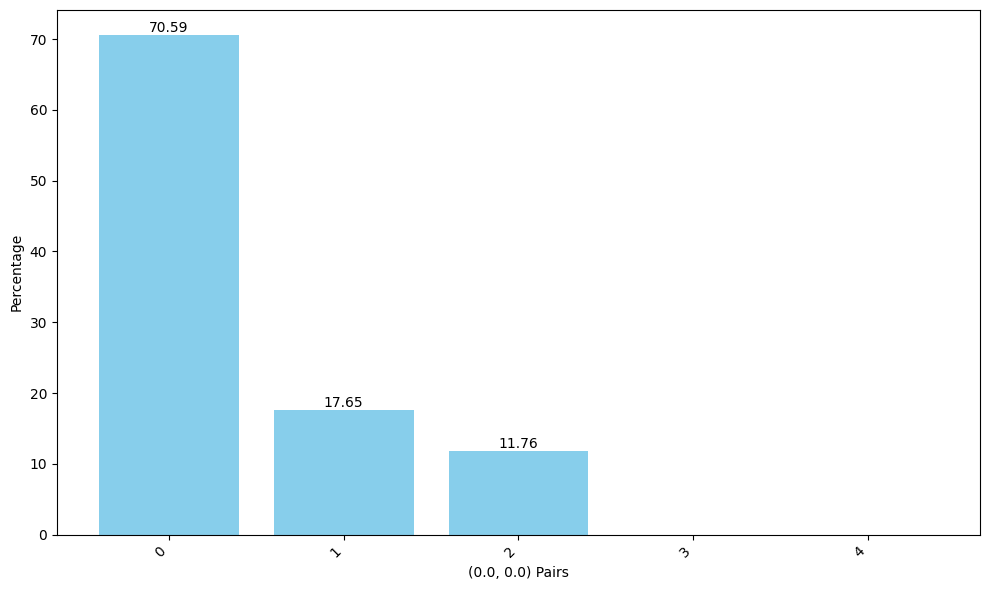

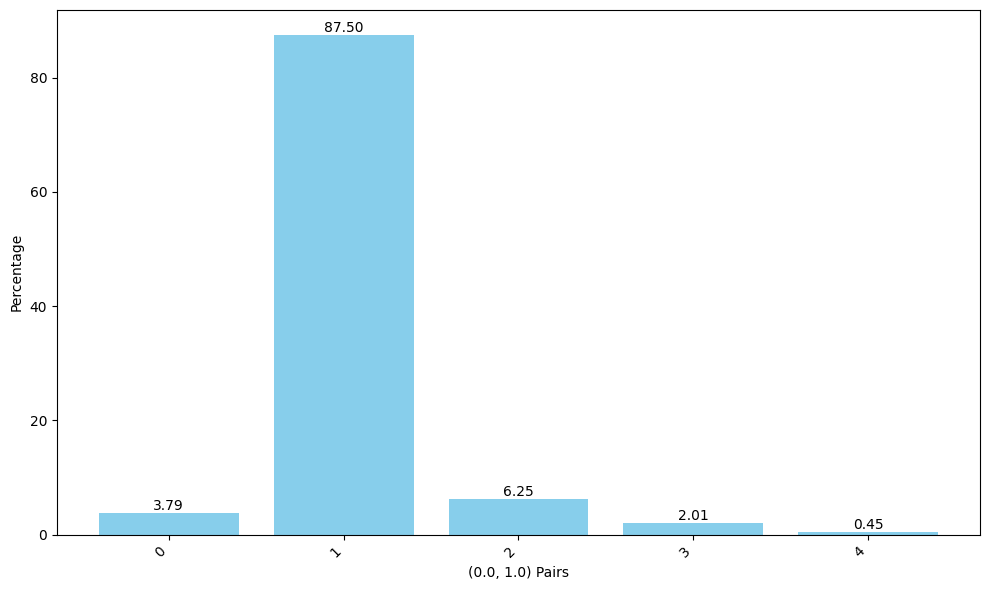

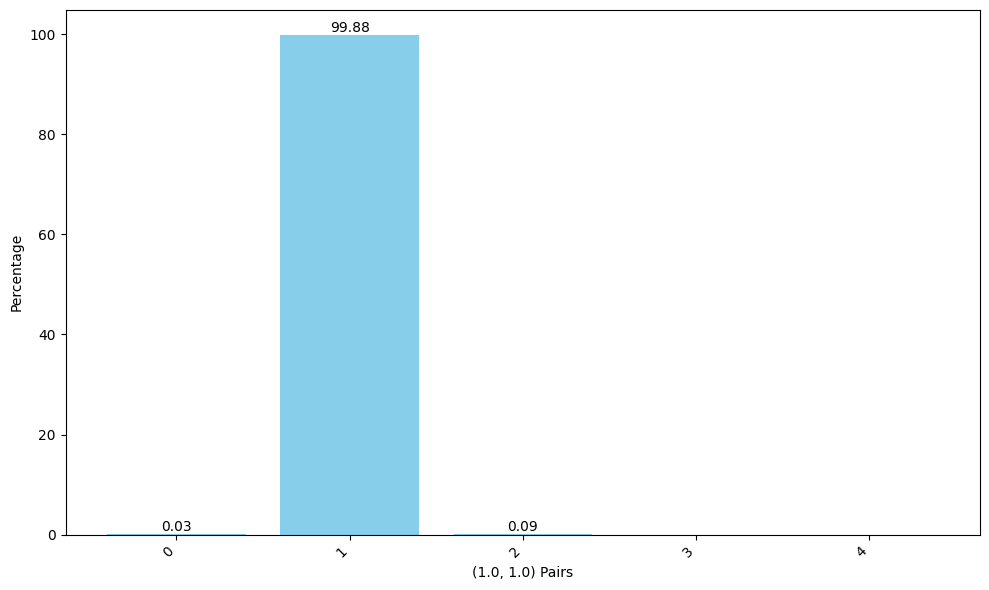

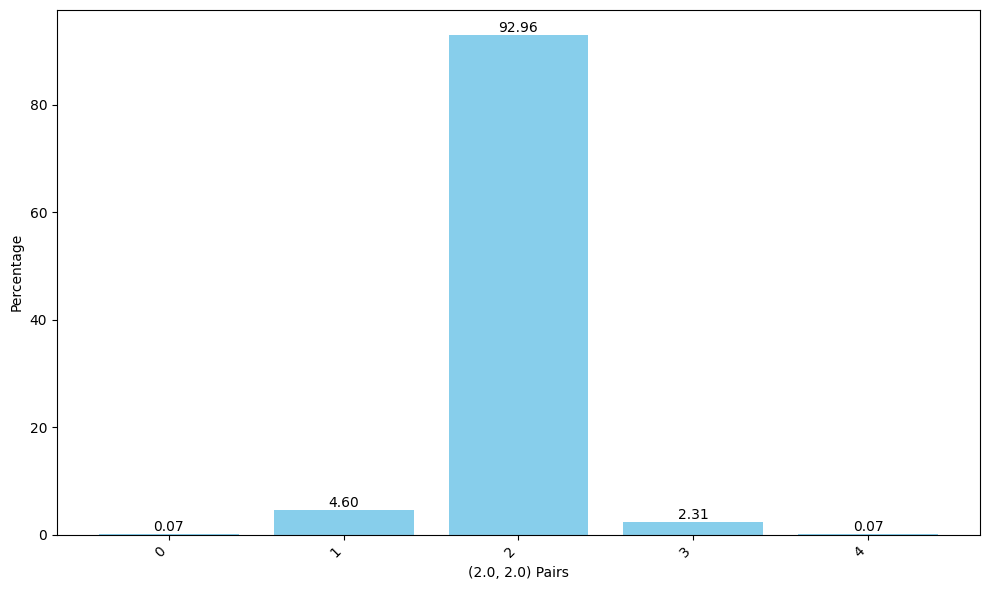

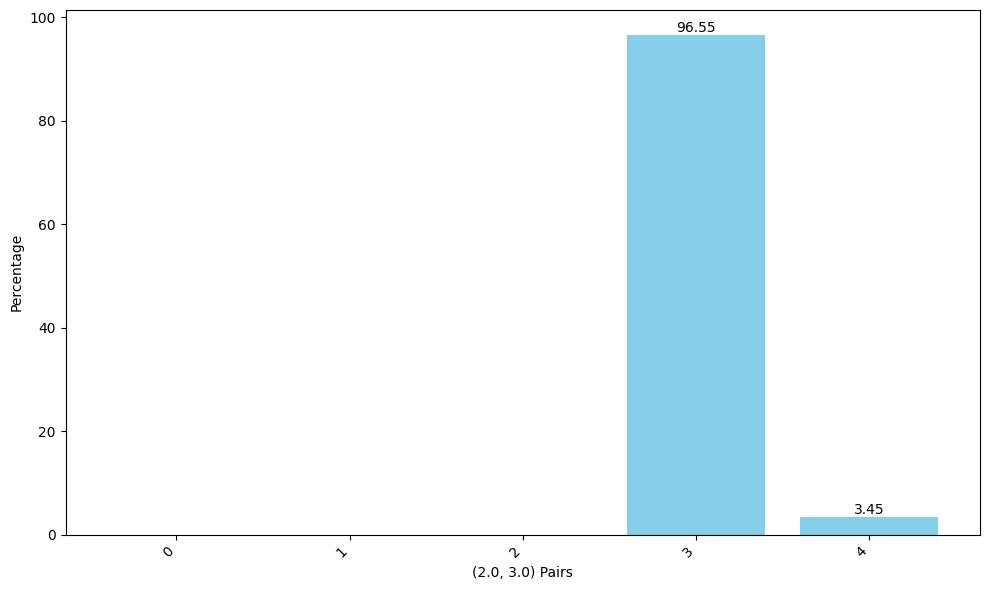

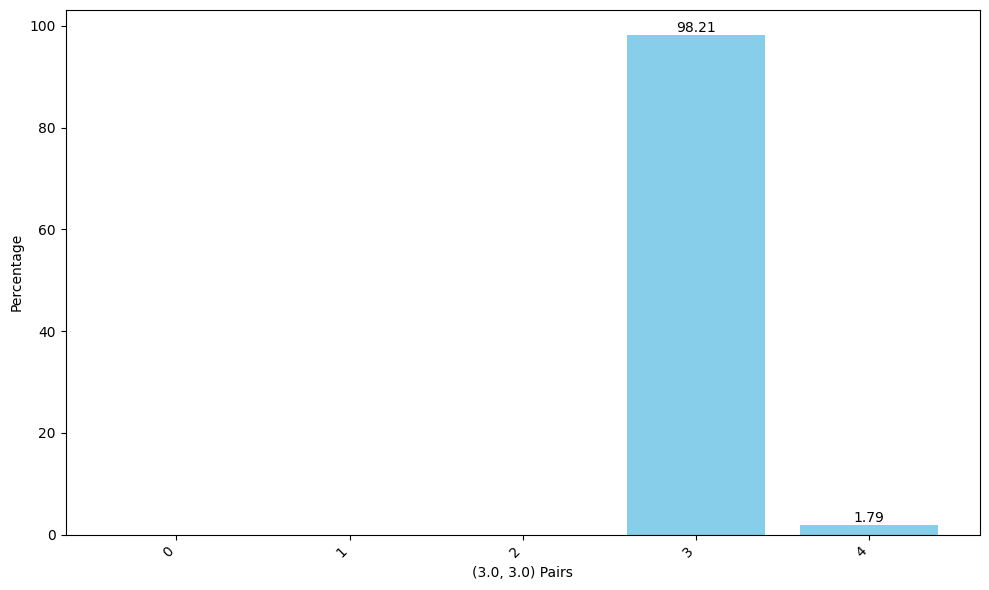

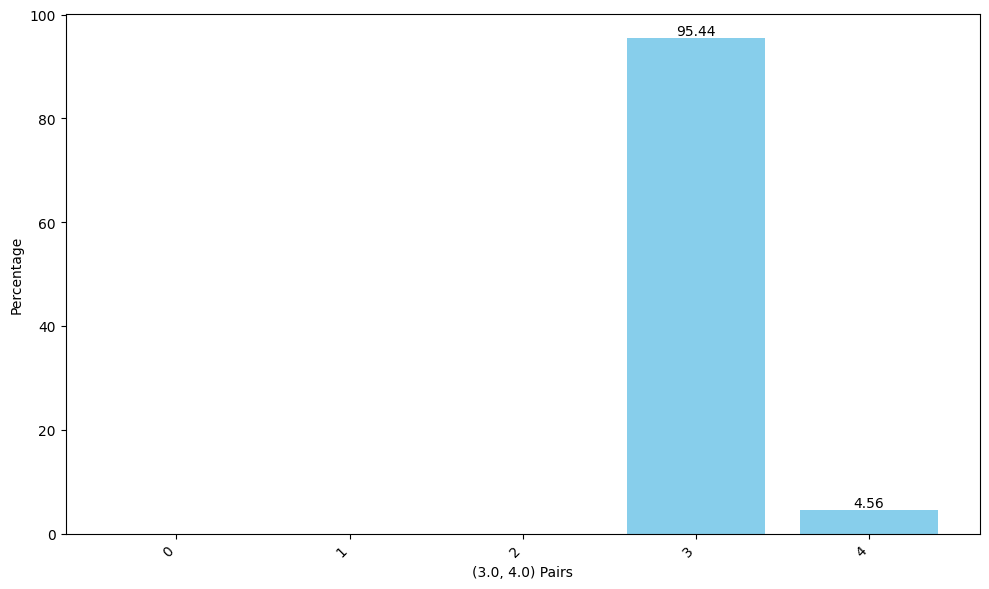

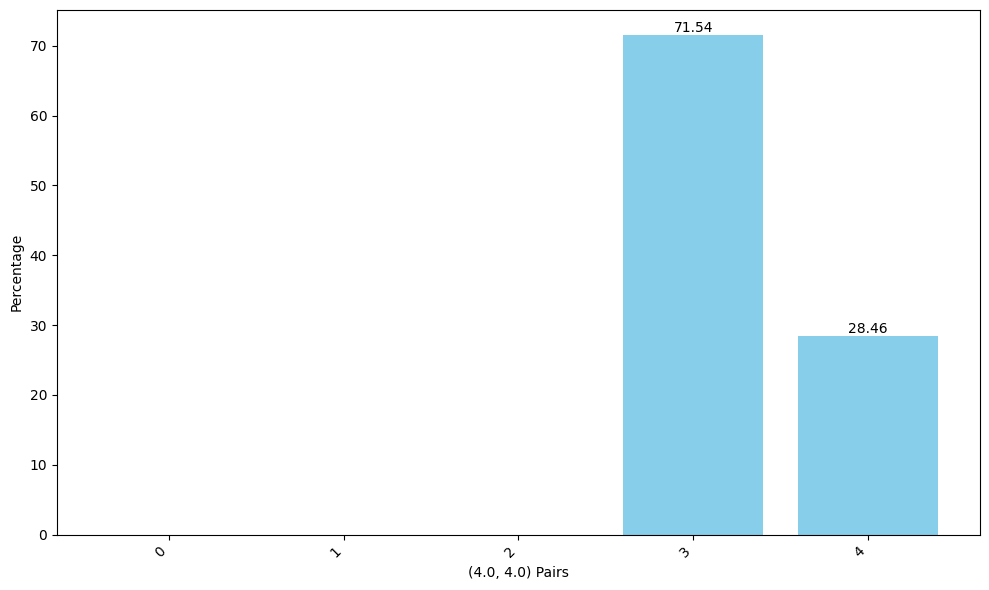

In [37]:
reporting(first_y_test, second_y_test, predicted_labels)